In [25]:
import pandas as pd

df_parquet = pd.read_parquet('../data/curated/')
df_parquet.head()

,PULocationID,pickup_hour_of_day,pickup_day_of_week,hvfhs_license_num,pickup_month,num_trips,avg(driver_pay),avg(trip_miles),avg(trip_time),avg(base_passenger_fare),LocationID,borough,num_wifi,log_num_wifi
0,20,0,3,HV0005,3,63,11.204444,3.608571,746.873016,14.068413,20.0,Bronx,1.0,0.000000
1,84,0,3,HV0005,3,3,9.116667,2.683000,635.000000,11.400000,84.0,Staten Island,5.0,1.609438
2,216,1,3,HV0005,3,47,16.002340,5.804106,892.340426,18.185106,216.0,Queens,2.0,0.693147
3,131,2,3,HV0003,3,19,17.428421,6.834211,895.894737,22.397368,131.0,Queens,1.0,0.000000
4,33,3,3,HV0005,3,12,12.937500,4.484417,865.833333,15.416667,33.0,Brooklyn,27.0,3.295837


# Use only the readily accessible data

In [26]:
df_parquet_modelling = df_parquet.loc[:,['pickup_hour_of_day', 'pickup_day_of_week','hvfhs_license_num', 'log_num_wifi', 'pickup_month', 'num_trips', 'borough']]
df_parquet_modelling.head()

,pickup_hour_of_day,pickup_day_of_week,hvfhs_license_num,log_num_wifi,pickup_month,num_trips,borough
0,0,3,HV0005,0.000000,3,63,Bronx
1,0,3,HV0005,1.609438,3,3,Staten Island
2,1,3,HV0005,0.693147,3,47,Queens
3,2,3,HV0003,0.000000,3,19,Queens
4,3,3,HV0005,3.295837,3,12,Brooklyn


In [27]:
# One hot encode the categorical columns
# df_parquet_modelling = pd.get_dummies(df_parquet_modelling, columns=['pickup_hour_of_day', 'pickup_day_of_week', 'hvfhs_license_num', 'borough'])

In [28]:
df_parquet_modelling.loc[:,'hvfhs_license_num'] = df_parquet_modelling['hvfhs_license_num'].factorize()[0]
df_parquet_modelling.loc[:,'borough'] = df_parquet_modelling['borough'].factorize()[0]

In [29]:
# Find nan values
df_parquet_modelling.isna().sum()

pickup_hour_of_day        0
pickup_day_of_week        0
hvfhs_license_num         0
log_num_wifi          60539
pickup_month              0
num_trips                 0
borough                   0
dtype: int64

In [30]:
# Impute nan values with 0
df_parquet_modelling.fillna(0, inplace=True)

In [31]:
import numpy as np


df_parquet_modelling.loc[:, "log_num_trips"] = df_parquet_modelling["num_trips"].apply(lambda x: 0 if x == 0 else np.log(x))

In [32]:
# Split the data into training and testing sets based on the pickup_month
df_train = df_parquet_modelling[df_parquet_modelling['pickup_month'] < 6]
df_test = df_parquet_modelling[df_parquet_modelling['pickup_month'] >= 6]

print(df_train.shape, df_test.shape)

(425542, 8) (85455, 8)


In [33]:
# Split the data into features and target
X_train = df_train.drop(columns=['num_trips', 'log_num_trips'])
y_train = df_train['log_num_trips']
X_test = df_test.drop(columns=['num_trips', 'log_num_trips'])
y_test = df_test['log_num_trips']

<Axes: >

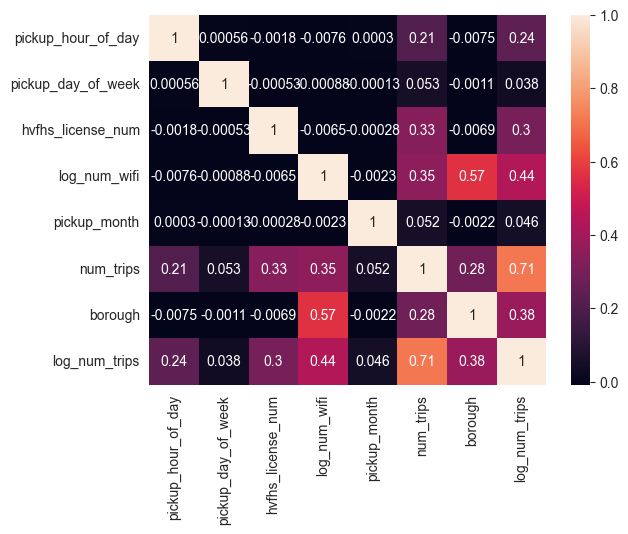

In [34]:
# Plot correlation matrix
import seaborn as sns

correlation_matrix = df_train.corr()
sns.heatmap(correlation_matrix, annot=True)

In [35]:
# Train a linear regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(np.exp(y_test), np.exp(y_pred))
print(mse)

52491.75897881298


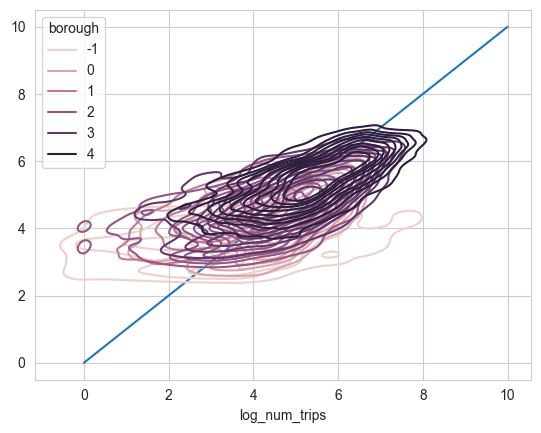

In [45]:
# Plot the predicted vs actual values
import matplotlib.pyplot as plt
sns.lineplot(x=[0,10], y=[0,10])
sns.kdeplot(x=y_test, y=y_pred, label='Actual', hue=X_test["borough"])
plt.show()

In [ ]:
# Train a random forest regression model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(np.exp(y_test), np.exp(y_pred))
print(mse)

In [ ]:
# Train a XGBoost regression model
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(np.exp(y_test), np.exp(y_pred))
print(mse)